In [22]:
import numpy as np
import torch 
import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
from generators.generators import ARMA, GARCH11, Noise
from generators.ESN import *
from sigkernel_.loss import compute_mmd_loss
from sigkernel_.kernels import gram

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Kernel calls test

In [23]:
# Set parameters
M_train = 50    # Number of training samples (collection of samples from a given mean reversion parameter)
M_test  = 10    # Number of test samples
N       = 20    # Number of path per sample (with the same distribution)
length  = 200   # Length of each path (time steps)

time_steps = np.linspace(0, 1, length+1)
max_T      = 1
min_T      = 1e-6

# Pick target (parameter to regress) from ['mean_rev', 'vol', 'hurst']
targets = ['mean_rev', 'vol', 'hurst']
target = targets[0]

In [24]:
# FBM for OU process (need to install to euler environment)
from fbm import FBM

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def fOU_generator(a,n=0.3,h=0.2,length=300):
    '''
    Generate a fractional Ornstein-Uhlenbeck process using the following SDE:
    dX_t = -a*(X_t - m)dt + n*dW_t
    where W_t is a fractional Brownian motion with Hurst parameter H = h.

    Arguments:
    a (float): Mean reversion speed
    n (float): Volatility
    h (float): Hurst parameter
    length (int): Length of the process

    Returns:
    np.array: Fractional Ornstein-Uhlenbeck process
    
    '''
    
    fbm_increments = np.diff(FBM(length, h).fbm())
    x0 = np.random.normal(1,0.1)
    x0 = 0.5
    m = x0
    price = [x0]
    for i in range(length):
        p = price[i] - a*(price[i]-m) + n*fbm_increments[i]
        price.append(p)
    return np.array(price)


def generate_process_dat_fOU(N, M, length, time_steps, max_T = 1e0, min_T = 1e-6, n = 0.3, h = 0.2, a=0.5, target = 'mean_rev'):
    '''
    Generate M samples of N paths of a fractional Ornstein-Uhlenbeck process using the following SDE:
    dX_t = -a*(X_t - m)dt + n*dW_t
    where W_t is a fractional Brownian motion with Hurst parameter H = h.
    where a is drawn from a uniform distribution between max_T and min_T and is the target variable.

    Arguments:
        N (int): Number of paths
        M (int): Number of samples
        length (int): Length of the process
        time_steps (np.array): Time steps
        max_T (float): Maximum value of the mean reversion
        min_T (float): Minimum value of the mean reversion
        n (float): Volatility
        h (float): Hurst parameter
        a (float): Mean reversion speed
        target (str): Target variable to predict ['mean_rev', 'vol', 'hurst'] (generates paths based on these variables)

    Returns:
        torch.Tensor: Scaled and formatted paths of the fractional Ornstein-Uhlenbeck process
        torch.Tensor: Mean reversion/volatility/hurst values

    '''
    assert target in ['mean_rev', 'vol', 'hurst'], "Target must be either 'mean_rev', 'vol' or 'hurst'"

    if target == 'mean_rev':
        y = np.array((max_T-min_T)*np.random.rand(M)+min_T)
        X = np.zeros((M, N, length+1))
        for i, scale in enumerate(y):
            for j in range(N):
                X[i,j] = np.exp(fOU_generator(scale,n,h,length))
    elif target == 'vol':
        max_T = 0.8
        min_T = 0.1
        y = np.array((max_T-min_T)*np.random.rand(M)+min_T)
        X = np.zeros((M, N, length+1))
        for i, scale in enumerate(y):
            for j in range(N):
                X[i,j] = np.exp(fOU_generator(a,scale,h,length))
    elif target == 'hurst':
        max_T = 0.8
        min_T = 0.1
        y = np.array((max_T-min_T)*np.random.rand(M)+min_T)
        X = np.zeros((M, N, length+1))
        for i, scale in enumerate(y):
            for j in range(N):
                X[i,j] = np.exp(fOU_generator(a,n,scale,length))

    # Ensure uniform shape for stacking
    X = np.array([np.array(intermediate) for intermediate in X])  # Shape: [M, N, length, 1]

    # Validate dimensions
    if not all(arr.shape == X[0][0].shape for sample in X for arr in sample):
        raise ValueError("All paths must have the same shape.")
    
    # Prepare time steps
    time_steps_repeated = np.tile(time_steps, (M, N, 1))  # Shape: [M, N, length]

    # Stack time steps and scaled paths
    X_stacked = np.stack([time_steps_repeated, X], axis=-1)  # Shape: [M, N, length, 2]

    # Convert to PyTorch tensor
    X_tensor = torch.tensor(X_stacked, dtype=torch.float64)
    y_tensor = torch.tensor(y, dtype=torch.float64)

    # Print final shape
    print("Final X shape:", X_tensor.shape,"Final y shape:", y_tensor.shape) 

    return X_tensor, y_tensor

In [25]:
np.random.seed(0)
X_train, y_train = generate_process_dat_fOU(N, M_train, length, time_steps, max_T = 1e0-min_T, min_T = 1e-6, 
                                            n = 0.3, h = 0.2, a = 0.5, target = target)

Final X shape: torch.Size([50, 20, 201, 2]) Final y shape: torch.Size([50])


In [26]:
# Get signature kernel

static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels           = 10 # number of levels in the truncated signature kernel
kernel_sigma       = 1e-6 # bandwidth parameter for the static kernel

kwargs = {
    'static_kernel_type': static_kernel_type,
    'n_levels': n_levels,
    'kernel_sigma': kernel_sigma,
}

# Define the signature kernel
signature_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs)

In [27]:
X_train = X_train[..., 1:]
# X_train = X_train.permute(0, 1, 2, 3)  # shape is [50, 20, 201, 1]
X_train.shape

torch.Size([50, 20, 201, 1])

In [28]:
sigma = 1.0

# Specify the static kernel 
static_kernel = ksig_pde.RBFKernel(sigma=sigma)

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel, dyadic_order=0)

print(X_train[0].shape, X_train[1].shape)

# Compute the signature kernel
mat1 = signature_kernel(X_train[0], X_train[1])
mat2 = sig_pde_kernel.compute_Gram(X_train[0], X_train[1])
print("signature_kernel shape:", mat1.shape)
print("sig_pde_kernel shape:", mat2.shape)
print("Absolute difference sum:", torch.abs(mat1 - mat2).sum().item())

torch.Size([20, 201, 1]) torch.Size([20, 201, 1])
signature_kernel shape: torch.Size([20, 20])
sig_pde_kernel shape: torch.Size([20, 20])
Absolute difference sum: 520.7064078777371


In [29]:
# Compute the static kernel Gram matrix between X_train[0] and X_train[1]
# Use the static_kernel defined earlier (RBFKernel)

static_gram = ksig_disc.kernels.RBFKernel(sigma=sigma)(X_train[0].reshape(X_train[0].shape[0], -1), X_train[1].reshape(X_train[1].shape[0], -1))
print("Static kernel Gram matrix shape:", static_gram.shape)


Static kernel Gram matrix shape: torch.Size([20, 20])


In [30]:
mat2

tensor([[1.0221, 1.0016, 1.0329, 1.0860, 1.0730, 1.0451, 1.0431, 1.0758, 1.0850,
         1.0821, 1.0613, 1.1020, 1.0262, 1.0414, 1.0746, 1.0605, 1.0524, 1.1128,
         1.0622, 1.0287],
        [1.0375, 1.0224, 1.0488, 1.1078, 1.0986, 1.0631, 1.0703, 1.0897, 1.1029,
         1.1079, 1.0798, 1.1194, 1.0397, 1.0655, 1.1104, 1.0851, 1.0763, 1.1390,
         1.0844, 1.0541],
        [1.0296, 1.1192, 0.9791, 0.9677, 1.0146, 0.9597, 1.1561, 0.9806, 0.9811,
         1.0760, 1.0799, 0.9415, 0.9648, 1.1140, 1.1689, 1.0614, 1.0982, 1.0519,
         1.0032, 1.0840],
        [1.0484, 1.1099, 1.0124, 1.0708, 1.0905, 1.0107, 1.1524, 1.0653, 1.0799,
         1.1425, 1.1417, 1.0531, 1.0169, 1.1227, 1.2108, 1.1066, 1.1426, 1.1495,
         1.0684, 1.0971],
        [1.0446, 1.1011, 1.0181, 1.0595, 1.0816, 1.0157, 1.1640, 1.0537, 1.0685,
         1.1406, 1.1176, 1.0379, 1.0089, 1.1330, 1.2027, 1.1021, 1.1200, 1.1400,
         1.0662, 1.0942],
        [1.0442, 1.0884, 1.0274, 1.0437, 1.0677, 1.0173, 1.1

# Generator test

In [31]:
torch.manual_seed(0)

x_ar = ARMA(T=100, p=2, q=0, phi=[0.7, -0.2]).generate(N=5, noise=Noise("normal"))
x_ma = ARMA(T=100, p=0, q=2, theta=[0.5, 0.2]).generate(N=5, noise=Noise("t", {"df": 7}))
x_arma = ARMA(T=100, p=2, q=1, phi=[0.7, -0.2], theta=[0.5]).generate(N=5, noise=Noise("normal"))
x_g  = GARCH11(T=200, omega=0.05, alpha=0.08, beta=0.9).generate(N=3, noise=Noise("normal"))

print(x_ar.shape, x_ma.shape, x_arma.shape, x_g.shape)

torch.Size([5, 100, 1]) torch.Size([5, 100, 1]) torch.Size([5, 100, 1]) torch.Size([3, 200, 1])


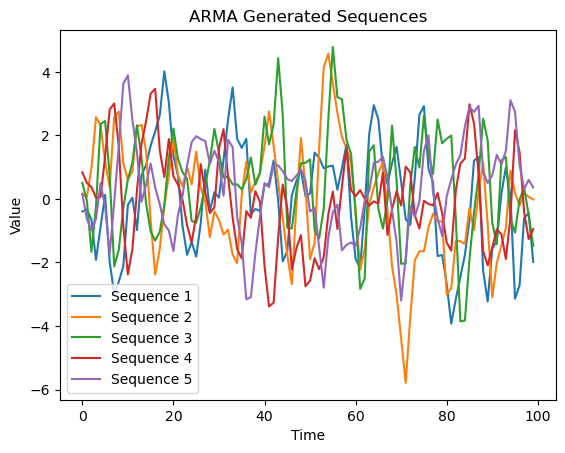

In [32]:
import matplotlib.pyplot as plt

for i in range(x_arma.shape[0]):
    plt.plot(x_arma[i].squeeze().numpy(), label=f'Sequence {i+1}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARMA Generated Sequences')
plt.legend()
plt.show()

# ESN

In [33]:
h, m, d = 500, 20, 1
A = 0.9 * torch.randn(h, h) / (h ** 0.5)
C = torch.randn(h, m) / (m ** 0.5)

gen = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05)
Z = gen(T=200, N=2)  
print(Z.shape)

torch.Size([2, 200, 1])


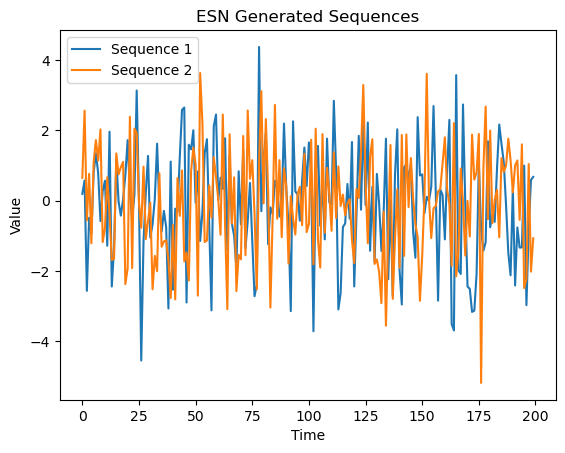

In [34]:
import matplotlib.pyplot as plt

for i in range(Z.shape[0]):
    plt.plot(Z[i].detach().squeeze().numpy(), label=f'Sequence {i+1}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ESN Generated Sequences')
plt.legend()
plt.show()

example learning

In [35]:
def rbf_mmd2(x, y, sigma=1.0):
    # x,y: (B, T, d) or (B, D) after flattening
    x = x.reshape(x.shape[0], -1)
    y = y.reshape(y.shape[0], -1)

    xx = (x[:, None, :] - x[None, :, :]).pow(2).sum(-1)
    yy = (y[:, None, :] - y[None, :, :]).pow(2).sum(-1)
    xy = (x[:, None, :] - y[None, :, :]).pow(2).sum(-1)

    kxx = torch.exp(-xx / (2 * sigma**2))
    kyy = torch.exp(-yy / (2 * sigma**2))
    kxy = torch.exp(-xy / (2 * sigma**2))

    return kxx.mean() + kyy.mean() - 2 * kxy.mean()


# fixed reservoir
h, m, d = 300, 20, 1
A = torch.randn(h, h) / (h ** 0.5)
C = torch.randn(h, m) / (m ** 0.5)

gen = ESNGenerator(A, C, out_dim=d, target_rho=0.9, xi_scale=1.0, eta_scale=0.1)
opt = torch.optim.Adam([gen.W], lr=1e-3)

T = 128
for step in range(2000):
    # real batch (example placeholder)
    Y = torch.randn(64, T, d, device=gen.A.device, dtype=gen.A.dtype)

    # fake batch
    Z = gen(T=T, N=Y.shape[0])  # (N,T,d)

    loss = rbf_mmd2(Z, Y, sigma=10.0)

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

    if step % 200 == 0:
        print(step, float(loss))


0 0.05855491757392883


KeyboardInterrupt: 

# check RBF kernel

In [66]:
# Get static kernel
static_sigma = 1e+1 # bandwidth parameter for the static kernel
rbf_kernel = ksig_disc.kernels.RBFKernel(sigma=static_sigma)

In [42]:
# Get discretized signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels           = 10 # number of levels in the truncated signature kernel
disc_sig_kernel_sigma       = 1e-5 # bandwidth parameter for the static kernel

kwargs = {
    'static_kernel_type': static_kernel_type,
    'n_levels': n_levels,
    'kernel_sigma': disc_sig_kernel_sigma,
}

# Define the discretized signature kernel
sig_disc_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs)

In [68]:
# Get pde signature kernel
pde_sig_sigma = 1e-1# bandwidth parameter for the static kernel
static_kernel = ksig_pde.RBFKernel(sigma=pde_sig_sigma) # define static kernel

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel, dyadic_order=0)

In [69]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 50  # number of samples
d = 1   # dimension of time series
p = 2   # AR order
q = 0   # MA order
phi = [0.7, -0.2] # AR coefficients
theta = None # MA coefficients

h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension, output dimension
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix

# Define data generator and esn
x_ar = ARMA(T=T, p=p, q=q, phi=phi, theta=theta)
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05)

target_generator = x_ar

# Kernel details --------------------------------
# choose one:
# kernel = sig_disc_kernel      # discretized signature kernel
kernel = sig_pde_kernel        # pde signature kernel
# kernel = rbf_kernel           # static kernel

if kernel is rbf_kernel:
    kernel_mode = "static"
else:
    kernel_mode = "sequential"

lead_lag = False
lags = 1

# Training details ------------------------------
epochs=2000
batch_size=20
lr=1e-3

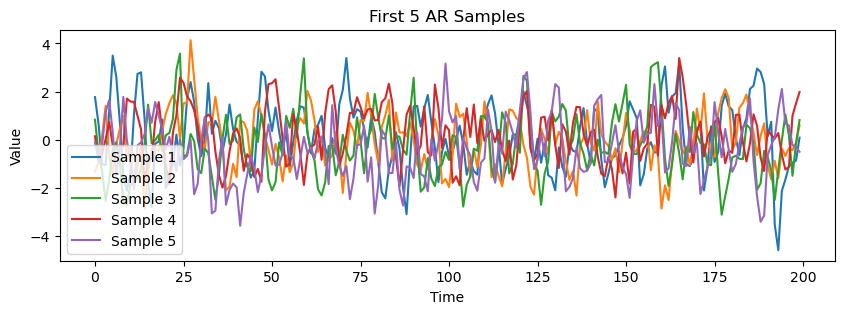

In [70]:
x_ar_samples = x_ar.generate(N=N, noise=Noise("normal"))

plt.figure(figsize=(10, 3))
for idx in range(5):
    plt.plot(x_ar_samples[idx].squeeze().numpy(), label=f'Sample {idx+1}')
plt.title('First 5 AR Samples')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

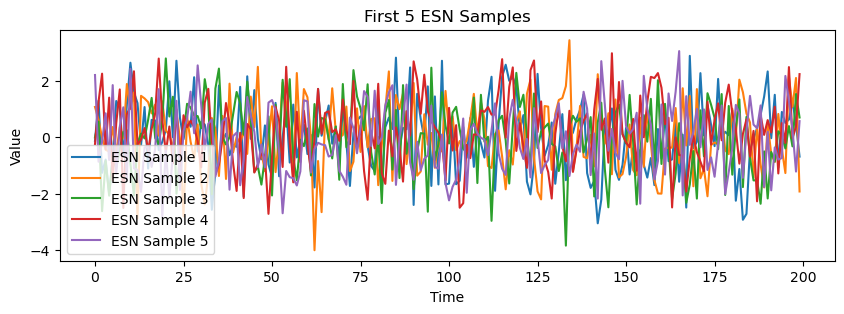

In [71]:
Z_esn = esn(N=N, T=T)
plt.figure(figsize=(10, 3))
for idx in range(5):
    plt.plot(Z_esn.detach().cpu().numpy()[idx].squeeze(), label=f'ESN Sample {idx+1}')
plt.title('First 5 ESN Samples')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [73]:
with torch.no_grad():
    X_compare = x_ar.generate(N=N, noise=Noise("normal")).to(device=device, dtype=dtype)
    Z_compare = esn(T=T, N=N).to(device=device, dtype=dtype)

# mmd_compare_sig_pde = compute_mmd_loss(sig_pde_kernel, X_compare, Z_compare, lead_lag, lags)
# mmd_compare_sig_disc = compute_mmd_loss(sig_disc_kernel, X_compare, Z_compare, lead_lag, lags)
# mmd_compare_static = compute_mmd_loss(rbf_kernel, X_compare.reshape(N, -1), Z_compare.reshape(N, -1), lead_lag, lags)
# print(f"MMD (PDE Sig Kernel) between AR and ESN samples: {mmd_compare_sig_pde.item():.6f}")
# print(f"MMD (Disc Sig Kernel) between AR and ESN samples: {mmd_compare_sig_disc.item():.6f}")
# print(f"MMD (Static RBF Kernel) between AR and ESN samples: {mmd_compare_static.item():.6f}")

In [74]:
sig_pde_kernel.compute_Gram(X_compare, Z_compare)

tensor([[8.8691e+05, 1.7640e+06, 2.1031e+05,  ..., 1.6203e+04, 4.8333e+04,
         8.8143e+04],
        [1.9618e+05, 1.5597e+05, 8.6062e+05,  ..., 7.0847e+06, 3.1731e+06,
         1.3492e+05],
        [1.2042e+06, 4.7678e+05, 5.3116e+04,  ..., 2.7288e+05, 4.5087e+05,
         4.2038e+05],
        ...,
        [9.7058e+04, 2.3040e+06, 2.7811e+05,  ..., 8.1256e+05, 1.7325e+06,
         2.0277e+05],
        [8.8821e+05, 3.4474e+05, 1.9093e+07,  ..., 8.5979e+06, 5.8589e+04,
         1.7391e+05],
        [7.5094e+05, 1.6284e+07, 2.2883e+05,  ..., 9.7894e+04, 1.8752e+06,
         1.0374e+05]], dtype=torch.float64)

In [75]:
rbf_kernel(X_compare.reshape(N, -1), Z_compare.reshape(N, -1))

tensor([[0.0057, 0.0013, 0.0011,  ..., 0.0033, 0.0017, 0.0048],
        [0.0043, 0.0008, 0.0017,  ..., 0.0029, 0.0008, 0.0020],
        [0.0068, 0.0014, 0.0075,  ..., 0.0015, 0.0017, 0.0039],
        ...,
        [0.0009, 0.0006, 0.0009,  ..., 0.0009, 0.0008, 0.0008],
        [0.0026, 0.0006, 0.0011,  ..., 0.0019, 0.0014, 0.0007],
        [0.0031, 0.0015, 0.0034,  ..., 0.0032, 0.0027, 0.0015]],
       dtype=torch.float64)